<a href="https://colab.research.google.com/github/cdario79/FiltroFakeNews/blob/main/Filtro_per_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Filtro per Fake News
Il problema delle fake news è cresciuto esponenzialmente nell'ultimo decennio a causa della crescente diffusione dei social network, il governo degli Stati Uniti ha deciso di muoversi a tal proposito, incaricando la tua azienda di realizzare un plug-in per chrome in grado di riconoscere se una notizia è falsa. Il tuo compito è quello di realizzare il modello in grado di riconoscere le notizie false, che poi il team di machine learning enginner e web developer metterà in produzione. Ti vengono messi a disposizioni due raccolte di notizie, una contenente solo notizie false e l'altra contenente solo notizie vere, utilizzale per addestrare il tuo modello.

### [Link al dataset](https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip)

Parti da un'accurata analisi, rispondendo a domande come:
- le fake news sono più frequenti in una determinata categoria?
- per ogni categoria, ci sono argomenti che sono più soggetti alle fake news?
- I titoli delle fake news presentano dei pattern?

Una volta addestrato il modello esportalo [utilizzando pickle](https://scikit-learn.org/stable/model_persistence.html) così che i tuoi colleghi possano metterlo in produzione.

## IMPORTAZIONE LIBRERIE UTILIZZATE

In [82]:
# Text Processing Libraries
import re  # For regular expression operations
import os  # For operating system interfaces
import requests  # For making HTTP requests
from dateutil import parser  # For parsing dates

# Data Manipulation and Analysis
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations

# Data Visualization
import matplotlib.pyplot as plt  # For plotting graphs

# Machine Learning
import pickle  # For saving and loading the trained model
from sklearn.model_selection import train_test_split  # For splitting the dataset
from sklearn.feature_extraction.text import TfidfVectorizer  # For converting text to vectors
from sklearn.svm import SVC  # For Support Vector Classification
from sklearn.metrics import classification_report  # For generating classification reports

# Natural Language Processing
import nltk  # For Natural Language Processing
from nltk.tokenize import word_tokenize  # For tokenization
from nltk.tag import pos_tag  # For part-of-speech tagging
from nltk.chunk import ne_chunk  # For named entity recognition
from collections import Counter  # For counting occurrences
from nltk.corpus import stopwords  # For stop words

# Download NLTK data required for tokenization, part-of-speech tagging,
# named entity recognition, and named entities
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')

# Advanced Language Processing
import spacy  # For advanced language processing
from spacy.lang.en.stop_words import STOP_WORDS as english_stopwords  # For English stopwords from Spacy

# Load the Spacy model
nlp = spacy.load("en_core_web_sm")  # Load the Spacy model for English

# Gensim for Topic Modeling
import gensim
from gensim import corpora  # For handling corpora of text documents
from pprint import pprint  # For pretty-printing

# Word Cloud
from wordcloud import WordCloud  # For generating word clouds

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## PARAMETRI

In [3]:
# Google Drive File ID for orginal dataset
ORIGINAL_TRUE_NEWS_DATA_FILE_GDRIVE_ID = '1Q77cWcaKM6XiOOE1_2cEjuCaLFJRwq2f'
ORIGINAL_FAKE_NEWS_DATA_FILE_GDRIVE_ID = '1T3Ght1PgfcqZTdoYTqi7HhxYvIp1SJ-m'

In [4]:
CLEANED_TRUE_NEWS_DATA_FILE_GDRIVE_ID = '1D4q098C3aLifRCdseopfMThzYa-nDa4b'
CLEANED_FAKE_NEWS_DATA_FILE_GDRIVE_ID = '1Uk3b-kfst_MJ8YopmXGlMwu7Q7Sg-dix'

## FUNZIONI UTILIZZATE

In [5]:
def text_cleaner(text):
    """
    Cleans the input text by converting to lowercase, removing special characters,
    punctuation, numbers, and stop words, and performing lemmatization.

    Args:
        text (str): The input text to be cleaned.

    Returns:
        str: The cleaned and processed text.
    """
    if not text:  # Check if the text is None or empty
        return ""

    # Convert the text to lowercase
    text = text.lower()

    # Remove special characters, punctuation, and numbers using regular expressions
    text = re.sub(r'[^a-z0-9\s]', '', text)

    # Remove multiple spaces
    text = re.sub(' +', ' ', text)

    # Parse the text with Spacy
    document = nlp(text)

    # Lemmatize the text and remove stop words and numbers
    text = ' '.join(token.lemma_ for token in document if token.lemma_ not in english_stopwords and not token.is_digit)

    return text

In [6]:
def download_csv_from_google_drive(file_id):
    """
    Downloads a CSV file from Google Drive given the file_id.

    Args:
        file_id (str): The unique identifier for the Google Drive file.

    Returns:
        str: The absolute path to the downloaded file.
    """

    def get_confirm_token(response):
        """
        Retrieves the confirmation token from the response cookies if present.

        Args:
            response (requests.Response): The response object from the initial request.

        Returns:
            str: The confirmation token if found, otherwise None.
        """
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        return None

    def save_response_content(response, destination):
        """
        Saves the content of the response to a file in chunks.

        Args:
            response (requests.Response): The response object containing the file data.
            destination (str): The destination path where the file will be saved.
        """
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk:  # Filter out keep-alive new chunks
                    f.write(chunk)

    def download_file_from_google_drive(file_id, destination):
        """
        Handles the download process from Google Drive, managing potential confirmation tokens.

        Args:
            file_id (str): The unique identifier for the Google Drive file.
            destination (str): The destination path where the file will be saved.
        """
        URL = "https://drive.google.com/uc?export=download"
        session = requests.Session()

        response = session.get(URL, params={'id': file_id}, stream=True)
        token = get_confirm_token(response)

        if token:
            params = {'id': file_id, 'confirm': token}
            response = session.get(URL, params=params, stream=True)

        save_response_content(response, destination)

    file_name = f"{file_id}.csv"

    if not os.path.exists(file_name):
        print(f"File {file_name} non trovato. Scaricamento in corso ...")
        download_file_from_google_drive(file_id, file_name)
        print(f"File {file_name} scaricato correttamente.")
    else:
        print(f"File {file_name} già presente.")

    return os.path.abspath(file_name)

In [7]:
def show_and_sort_all_unique_value_of_column(column_name, current_df):
    with pd.option_context('display.max_rows', None):
        col_unique = current_df[column_name].sort_values().unique()
        df_col = pd.DataFrame(col_unique, columns=[column_name])
        print(df_col)

## CARICO LE NOTIZIE VERE

In [8]:
original_true_news_csv_path = download_csv_from_google_drive(ORIGINAL_TRUE_NEWS_DATA_FILE_GDRIVE_ID)

File 1Q77cWcaKM6XiOOE1_2cEjuCaLFJRwq2f.csv non trovato. Scaricamento in corso ...
File 1Q77cWcaKM6XiOOE1_2cEjuCaLFJRwq2f.csv scaricato correttamente.


In [9]:
df_true = pd.read_csv(original_true_news_csv_path)
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## CARICO LE NOTIZIE FALSE

In [10]:
original_fake_news_csv_path = download_csv_from_google_drive(ORIGINAL_FAKE_NEWS_DATA_FILE_GDRIVE_ID)

File 1T3Ght1PgfcqZTdoYTqi7HhxYvIp1SJ-m.csv non trovato. Scaricamento in corso ...
File 1T3Ght1PgfcqZTdoYTqi7HhxYvIp1SJ-m.csv scaricato correttamente.


In [11]:
df_fake = pd.read_csv(original_fake_news_csv_path)
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


## PREPROCESSING DELLE NOTIZIE VERE

In [12]:
"""
df_true_cleaned = df_true.copy()
df_true_cleaned['title'] = df_true_cleaned['title'].apply(text_cleaner)
df_true_cleaned['text'] = df_true_cleaned['text'].apply(text_cleaner)
df_true_cleaned.to_csv("true_news_cleaned.csv", index=False)
"""

'\ndf_true_cleaned = df_true.copy()\ndf_true_cleaned[\'title\'] = df_true_cleaned[\'title\'].apply(text_cleaner)\ndf_true_cleaned[\'text\'] = df_true_cleaned[\'text\'].apply(text_cleaner)\ndf_true_cleaned.to_csv("true_news_cleaned.csv", index=False)\n'

In [58]:
csv_true_new_file_name = download_csv_from_google_drive(CLEANED_TRUE_NEWS_DATA_FILE_GDRIVE_ID)
df_true_cleaned = pd.read_csv(csv_true_new_file_name)

File 1D4q098C3aLifRCdseopfMThzYa-nDa4b.csv già presente.


In [59]:
df_true_cleaned.dropna(inplace=True)

In [60]:
df_true_cleaned.head()

,title,text,subject,date
0,budget fight loom republicans flip fiscal script,washington reuter head conservative republican...,politicsNews,"December 31, 2017"
1,military accept transgender recruit monday pen...,washington reuter transgender people allow fir...,politicsNews,"December 29, 2017"
2,senior us republican senator let mr mueller job,washington reuter special counsel investigatio...,politicsNews,"December 31, 2017"
3,fbi russia probe help australian diplomat tipo...,washington reuters trump campaign adviser geor...,politicsNews,"December 30, 2017"
4,trump want postal service charge much amazon s...,seattlewashington reuters president donald tru...,politicsNews,"December 29, 2017"


## PREPROCESSING DELLE NOTIZIE FALSE

In [20]:
"""
df_fake_cleaned = df_true.copy()
df_fake_cleaned['title'] = df_fake_cleaned['title'].apply(text_cleaner)
df_fake_cleaned['text'] = df_fake_cleaned['text'].apply(text_cleaner)
df_fake_cleaned.to_csv("df_fake_cleaned.csv", index=False)
"""

'\ndf_fake_cleaned = df_true.copy()\ndf_fake_cleaned[\'title\'] = df_fake_cleaned[\'title\'].apply(text_cleaner)\ndf_fake_cleaned[\'text\'] = df_fake_cleaned[\'text\'].apply(text_cleaner)\ndf_fake_cleaned.to_csv("df_fake_cleaned.csv", index=False)\n'

In [62]:
csv_fake_new_file_name = download_csv_from_google_drive(CLEANED_FAKE_NEWS_DATA_FILE_GDRIVE_ID)
df_fake_cleaned = pd.read_csv(csv_fake_new_file_name)

File 1Uk3b-kfst_MJ8YopmXGlMwu7Q7Sg-dix.csv già presente.


In [63]:
df_fake_cleaned.dropna(inplace=True)

In [64]:
df_fake_cleaned.head()

,title,text,subject,date
0,donald trump send embarrass new year eve messa...,donald trump wish americans happy new year lea...,News,"December 31, 2017"
1,drunk bragging trump staffer start russian col...,house intelligence committee chairman devin nu...,News,"December 31, 2017"
2,sheriff david clarke become internet joke thre...,friday reveal former milwaukee sheriff david c...,News,"December 30, 2017"
3,trump obsessed even obamas name code website i...,christmas day donald trump announce would back...,News,"December 29, 2017"
4,pope francis call donald trump christmas speech,pope francis use annual christmas day message ...,News,"December 25, 2017"


## COSTRUZIONE DATAFRAME COMPLETO

In [65]:
# Aggiungi una colonna "label" per distinguere tra notizie vere (1) e false (0)
df_true_label = df_true_cleaned.copy()
df_true_label['label'] = 1
df_fake_label = df_fake_cleaned.copy()
df_fake_label['label'] = 0

# Unisci i dataset
df_full = pd.concat([df_true_label, df_fake_label])
df_full.sample(15)

,title,text,subject,date,label
11728,watch bill oreillys exclusive interview presid...,watch full oreillyfactor exclusive superbowl i...,politics,"Feb 5, 2017",0
17314,four nation meet resume stall afghan peace tal...,islamabad reuters afghanistan china pakistan u...,worldnews,"October 16, 2017",1
18044,north koreas kim jongun consider use year old ...,think next kim jongun prepare special force su...,left-news,"Aug 28, 2017",0
10878,minority trump supporter throw maxine water to...,video begin hispanic man tell videographer go ...,politics,"May 15, 2017",0
21416,indonesia buy billion worth russian jet,jakarta reuters indonesia buy sukhoi fighter ...,worldnews,"August 22, 2017",1
12773,senior probrexit minister gove back pm may dea...,london reuters british minister michael gove i...,worldnews,"December 8, 2017",1
19136,tale two city kurdish vote lay bare political ...,sulaimaniya iraq reuter kurdish leader describ...,worldnews,"September 25, 2017",1
6663,new carly fiorina website get push directly so...,probably know republican presidential candidat...,News,"April 28, 2016",0
11269,left go bonker bill oreilly say maxine water w...,maxine bad enemy black community americans nee...,politics,"Mar 28, 2017",0
22958,delirium spread lefts great russian conspiracy...,people year talk problem conspiracy theory bec...,Middle-east,"March 11, 2017",0


## Le fake news sono più frequenti in una determinata categoria?

Frequenza delle categorie:
subject
News               9050
politics           6433
left-news          4309
Government News    1498
US_News             783
Middle-east         778
Name: count, dtype: int64

Frequenza relativa delle categorie:
subject
News               0.396044
politics           0.281519
left-news          0.188569
Government News    0.065555
US_News            0.034265
Middle-east        0.034047
Name: count, dtype: float64


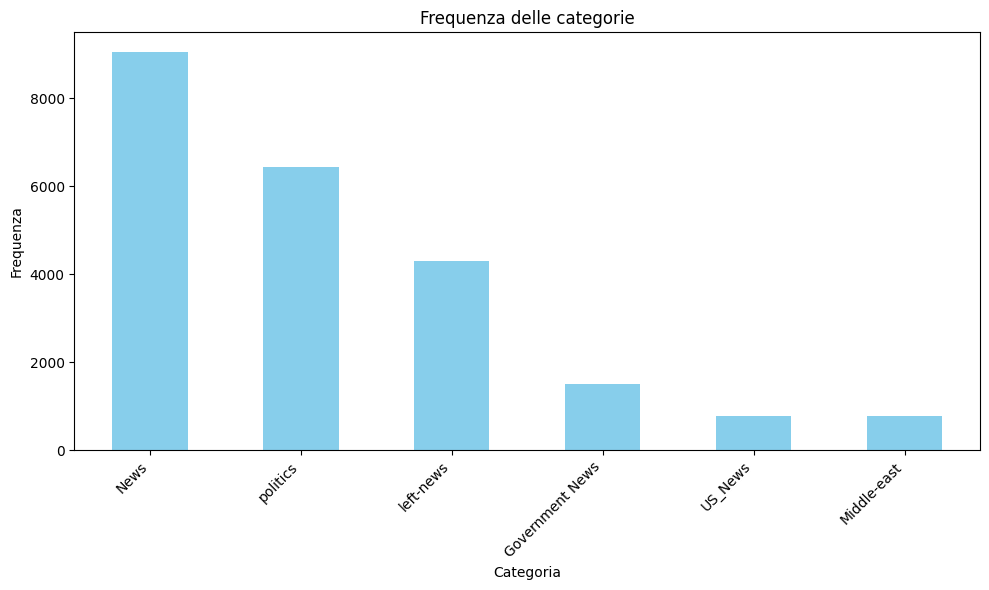

In [66]:
# Contare il numero di occorrenze per ciascuna categoria
frequenza_categorie = df_fake_cleaned['subject'].value_counts()

# Calcolare la frequenza di ciascuna categoria rispetto al totale
frequenza_relativa = frequenza_categorie / len(df_fake_cleaned)

print("Frequenza delle categorie:")
print(frequenza_categorie)
print("\nFrequenza relativa delle categorie:")
print(frequenza_relativa)

# Ordinare le categorie per frequenza in ordine decrescente
frequenza_categorie_ordinate = frequenza_categorie.sort_values(ascending=False)

# Creazione del grafico a barre ordinato per frequenza
plt.figure(figsize=(10, 6))
frequenza_categorie_ordinate.plot(kind='bar', color='skyblue')
plt.title('Frequenza delle categorie')
plt.xlabel('Categoria')
plt.ylabel('Frequenza')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Per ogni categoria, ci sono argomenti che sono più soggetti alle fake news?

LDA (Latent Dirichlet Allocation) è un modello di apprendimento automatico utilizzato per identificare argomenti nascosti all'interno di un insieme di documenti. Puoi utilizzare LDA per analizzare i testi degli articoli e identificare argomenti che potrebbero essere più soggetti alle fake news.

In [78]:
# Creazione di una lista di tokenizzati testo (data_words)
data_words = df_fake_cleaned['text'].apply(lambda x: x.split())

# Creazione del dizionario
id2word = corpora.Dictionary(data_words)

# Creazione del corpus
corpus = [id2word.doc2bow(text) for text in data_words]

In [79]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, passes = 3)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"us" + 0.008*"world" + 0.008*"war" + 0.007*"president" + 0.006*"say" '
  '+ 0.006*"military" + 0.005*"iran" + 0.005*"trump" + 0.005*"wire" + '
  '0.004*"country"'),
 (1,
  '0.021*"trump" + 0.015*"medium" + 0.013*"news" + 0.007*"wire" + 0.007*"cnn" '
  '+ 0.006*"say" + 0.006*"political" + 0.006*"story" + 0.006*"fake" + '
  '0.005*"like"'),
 (2,
  '0.017*"police" + 0.010*"say" + 0.009*"black" + 0.008*"officer" + '
  '0.008*"gun" + 0.006*"shoot" + 0.006*"shooting" + 0.005*"man" + '
  '0.005*"people" + 0.005*"life"'),
 (3,
  '0.035*"I" + 0.016*"say" + 0.009*"go" + 0.009*"woman" + 0.008*"people" + '
  '0.008*"get" + 0.006*"like" + 0.006*"one" + 0.006*"make" + 0.006*"trump"'),
 (4,
  '0.007*"state" + 0.005*"government" + 0.005*"year" + 0.005*"say" + '
  '0.005*"people" + 0.005*"new" + 0.004*"student" + 0.004*"million" + '
  '0.004*"would" + 0.004*"make"'),
 (5,
  '0.013*"obama" + 0.013*"vote" + 0.012*"president" + 0.011*"election" + '
  '0.010*"party" + 0.008*"state" + 0.008*"r

In [80]:
perplexity = lda_model.log_perplexity(corpus)

print(f'Perplexity del modello LDA: {perplexity}')

Perplexity del modello LDA: -8.832458318763758


In [92]:
topics = lda_model.print_topics()
topics

[(0,
  '0.009*"us" + 0.008*"world" + 0.008*"war" + 0.007*"president" + 0.006*"say" + 0.006*"military" + 0.005*"iran" + 0.005*"trump" + 0.005*"wire" + 0.004*"country"'),
 (1,
  '0.021*"trump" + 0.015*"medium" + 0.013*"news" + 0.007*"wire" + 0.007*"cnn" + 0.006*"say" + 0.006*"political" + 0.006*"story" + 0.006*"fake" + 0.005*"like"'),
 (2,
  '0.017*"police" + 0.010*"say" + 0.009*"black" + 0.008*"officer" + 0.008*"gun" + 0.006*"shoot" + 0.006*"shooting" + 0.005*"man" + 0.005*"people" + 0.005*"life"'),
 (3,
  '0.035*"I" + 0.016*"say" + 0.009*"go" + 0.009*"woman" + 0.008*"people" + 0.008*"get" + 0.006*"like" + 0.006*"one" + 0.006*"make" + 0.006*"trump"'),
 (4,
  '0.007*"state" + 0.005*"government" + 0.005*"year" + 0.005*"say" + 0.005*"people" + 0.005*"new" + 0.004*"student" + 0.004*"million" + 0.004*"would" + 0.004*"make"'),
 (5,
  '0.013*"obama" + 0.013*"vote" + 0.012*"president" + 0.011*"election" + 0.010*"party" + 0.008*"state" + 0.008*"republican" + 0.007*"would" + 0.007*"clinton" + 0.0

In [93]:
def identify_susceptible_topics(topics, df):
    topic_susceptibility = {}

    for topic_id, keywords_str in topics:
        topic_susceptibility[topic_id] = {}

        # Extract keywords from the string
        keywords = re.findall(r'\"(.+?)\"', keywords_str)

        # Check each category
        for category in df['subject'].unique():
            category_articles = df[df['subject'] == category]

            # Check if any articles contain keywords from this topic
            for _, article in category_articles.iterrows():
                if any(keyword in article['text'] for keyword in keywords):
                    if category not in topic_susceptibility[topic_id]:
                        topic_susceptibility[topic_id][category] = 1
                    else:
                        topic_susceptibility[topic_id][category] += 1

    return topic_susceptibility

topic_susceptibility = identify_susceptible_topics(topics, df_fake_cleaned)
print("Topic Susceptibility:")
print(topic_susceptibility)

Topic Susceptibility:
{0: {'News': 9045, 'politics': 5995, 'Government News': 1410, 'left-news': 4120, 'US_News': 783, 'Middle-east': 778}, 1: {'News': 8955, 'politics': 5700, 'Government News': 1297, 'left-news': 3926, 'US_News': 782, 'Middle-east': 777}, 2: {'News': 8932, 'politics': 5484, 'Government News': 1318, 'left-news': 3916, 'US_News': 739, 'Middle-east': 734}, 3: {'News': 9050, 'politics': 6103, 'Government News': 1426, 'left-news': 4157, 'US_News': 775, 'Middle-east': 770}, 4: {'News': 9022, 'politics': 5690, 'Government News': 1368, 'left-news': 3983, 'US_News': 725, 'Middle-east': 720}, 5: {'News': 8968, 'politics': 5727, 'Government News': 1362, 'left-news': 3916, 'US_News': 688, 'Middle-east': 683}, 6: {'News': 9031, 'politics': 5769, 'Government News': 1404, 'left-news': 4037, 'US_News': 775, 'Middle-east': 770}, 7: {'News': 8702, 'politics': 5249, 'Government News': 1284, 'left-news': 3732, 'US_News': 755, 'Middle-east': 750}, 8: {'News': 9047, 'politics': 6059, 'Gove

In [99]:
import re

def format_topic_string(topic_string):
    # Estrai il numero del topic
    topic_id, keywords_str = topic_string.split(", ")

    # Estrai le parole chiave e le relative probabilità
    keywords = re.findall(r'"([^"]*)"', keywords_str)
    probabilities = re.findall(r'0\.\d+', keywords_str)

    # Combina le parole chiave con le probabilità e formatta la stringa
    formatted_keywords = [f"{prob} - {word}" for prob, word in zip(probabilities, keywords)]
    formatted_string = '\n'.join(formatted_keywords)

    return formatted_string



TOPIC 0
Keywords: 
0.009 - us
0.008 - world
0.008 - war
0.007 - president
0.006 - say
0.006 - military
0.005 - iran
0.005 - trump
0.005 - wire
0.004 - country



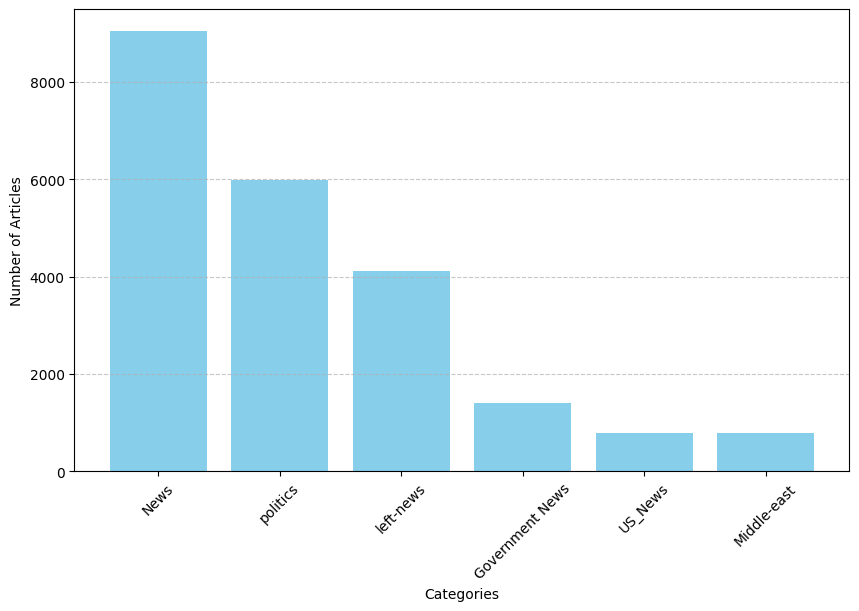



TOPIC 1
Keywords: 
0.021 - trump
0.015 - medium
0.013 - news
0.007 - wire
0.007 - cnn
0.006 - say
0.006 - political
0.006 - story
0.006 - fake
0.005 - like



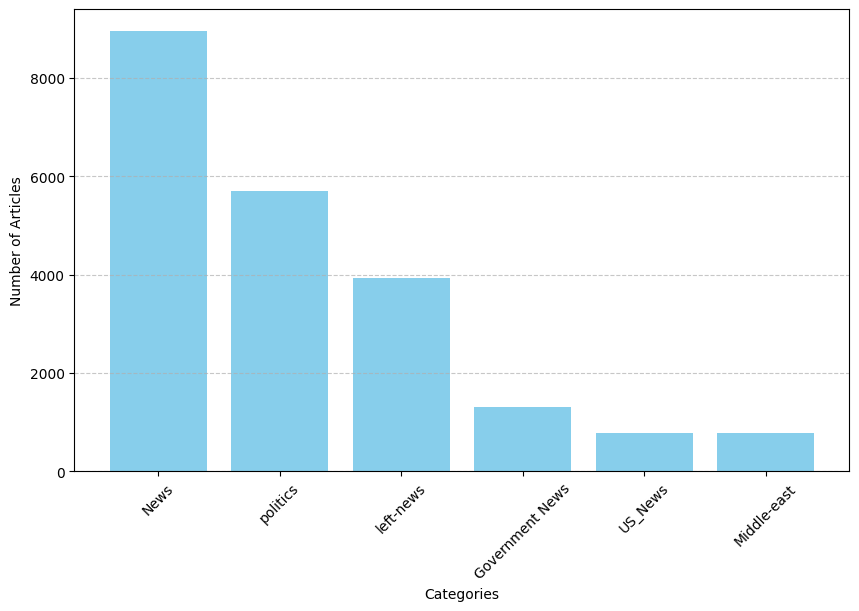



TOPIC 2
Keywords: 
0.017 - police
0.010 - say
0.009 - black
0.008 - officer
0.008 - gun
0.006 - shoot
0.006 - shooting
0.005 - man
0.005 - people
0.005 - life



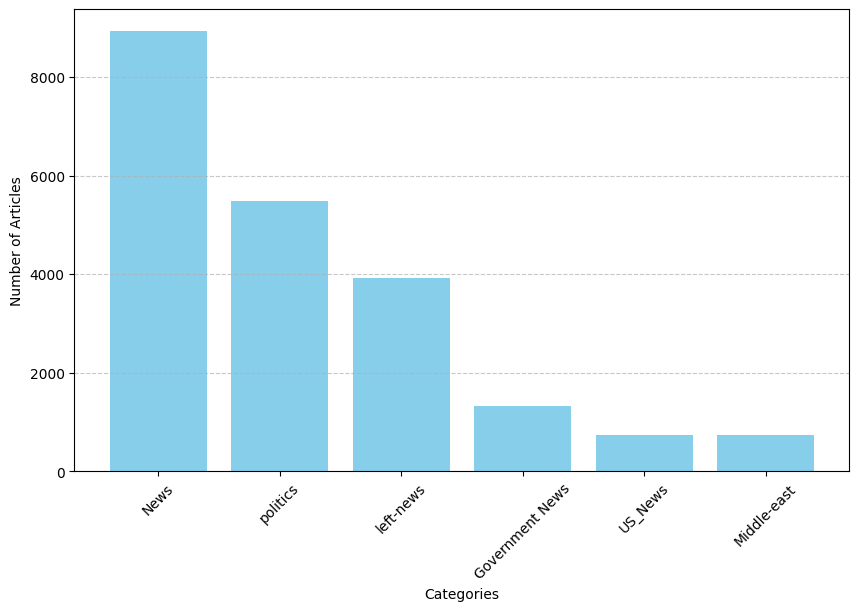



TOPIC 3
Keywords: 
0.035 - I
0.016 - say
0.009 - go
0.009 - woman
0.008 - people
0.008 - get
0.006 - like
0.006 - one
0.006 - make
0.006 - trump



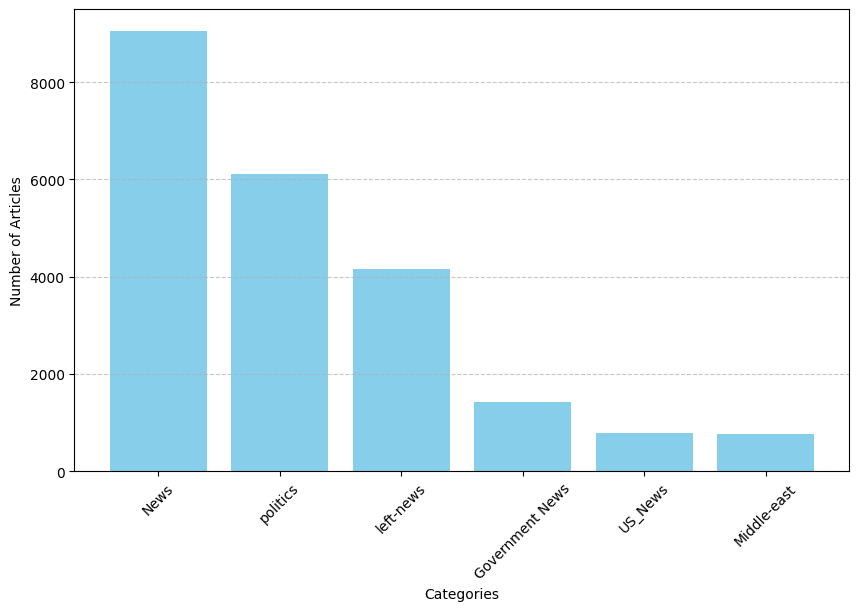



TOPIC 4
Keywords: 
0.007 - state
0.005 - government
0.005 - year
0.005 - say
0.005 - people
0.005 - new
0.004 - student
0.004 - million
0.004 - would
0.004 - make



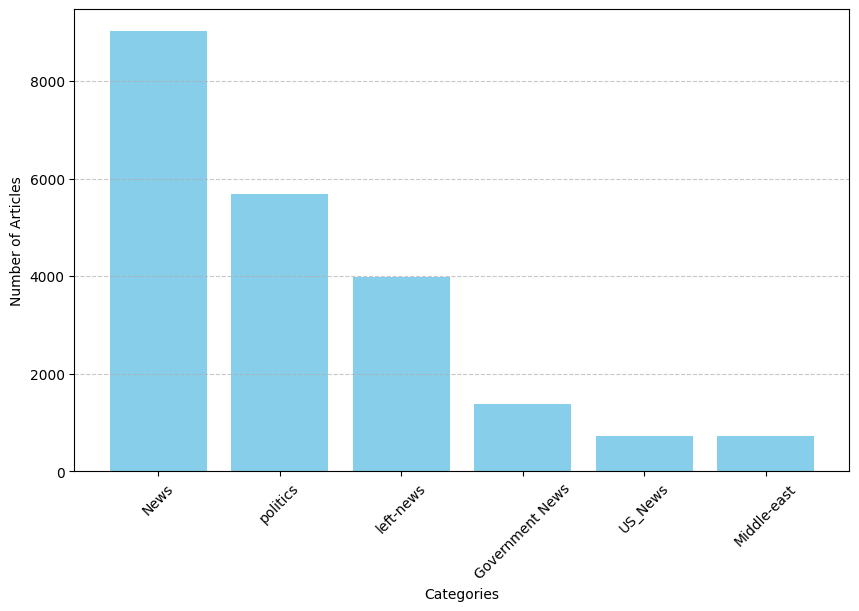



TOPIC 5
Keywords: 
0.013 - obama
0.013 - vote
0.012 - president
0.011 - election
0.010 - party
0.008 - state
0.008 - republican
0.007 - would
0.007 - clinton
0.007 - say



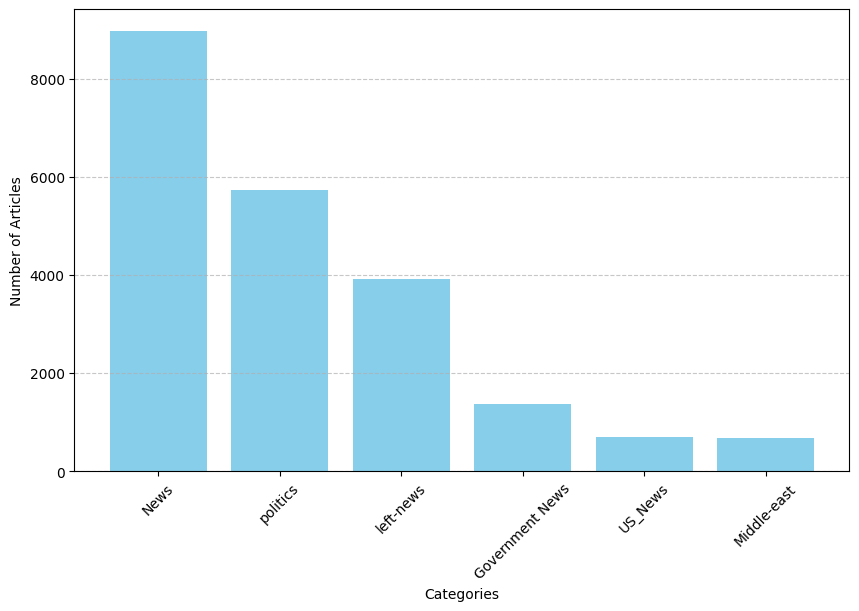



TOPIC 6
Keywords: 
0.014 - us
0.013 - syria
0.009 - say
0.007 - syrian
0.007 - muslim
0.006 - country
0.006 - terrorist
0.005 - government
0.005 - state
0.005 - isis



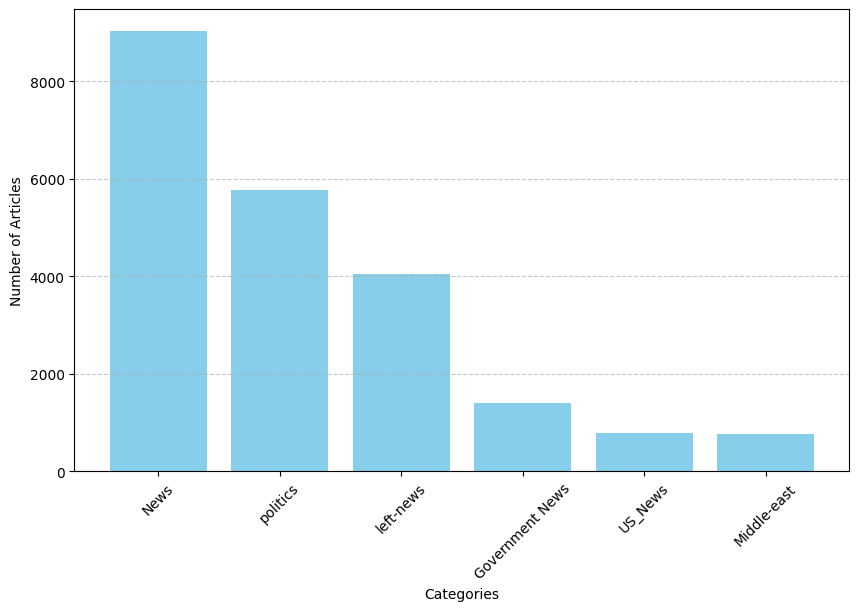



TOPIC 7
Keywords: 
0.008 - fbi
0.008 - report
0.007 - case
0.007 - federal
0.007 - story
0.006 - wire
0.006 - say
0.005 - see
0.005 - shooter
0.005 - agent



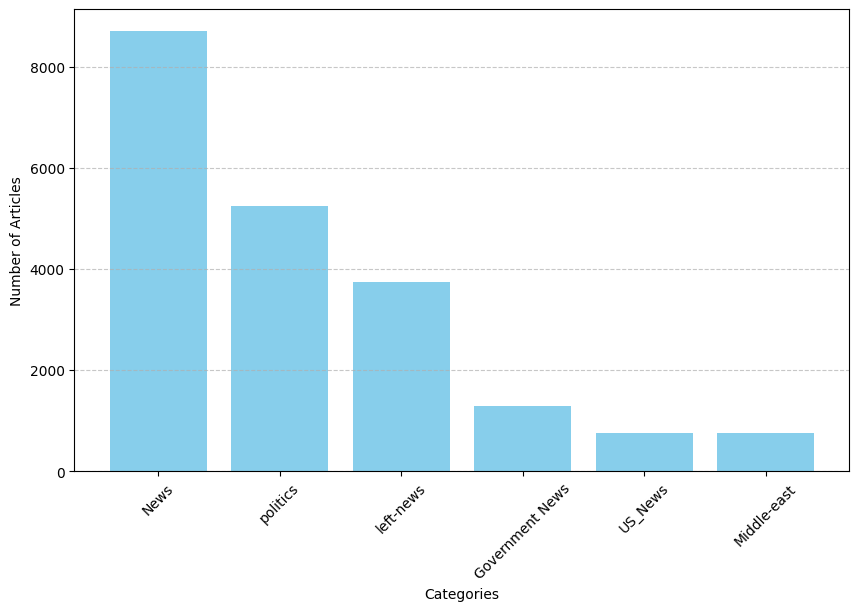



TOPIC 8
Keywords: 
0.065 - trump
0.014 - donald
0.011 - say
0.011 - president
0.007 - go
0.006 - I
0.006 - make
0.006 - would
0.005 - get
0.005 - people



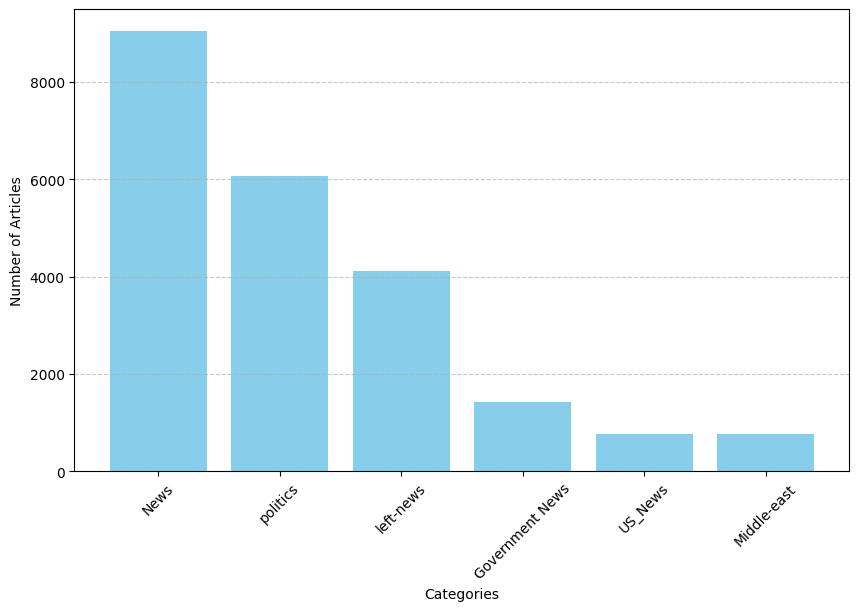



TOPIC 9
Keywords: 
0.017 - clinton
0.008 - russian
0.008 - email
0.008 - say
0.008 - russia
0.007 - hillary
0.007 - intelligence
0.007 - cia
0.006 - fbi
0.006 - state



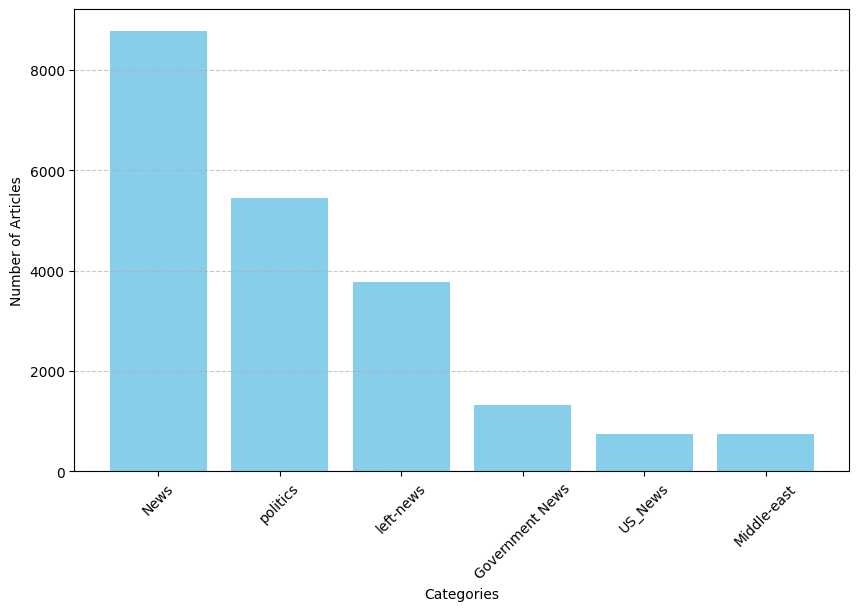

In [103]:
def plot_topic_susceptibility(topic_susceptibility, topics):
    for topic_id, category_counts in topic_susceptibility.items():
        categories = list(category_counts.keys())
        counts = list(category_counts.values())

        # Sort categories and counts based on counts
        categories_sorted = [x for _, x in sorted(zip(counts, categories), reverse=True)]
        counts_sorted = sorted(counts, reverse=True)

        # Get topic keywords
        topic_keywords = topics[topic_id]

        formatted_string = format_topic_string(str(topic_keywords))

        plt.figure(figsize=(10, 6))
        plt.bar(categories_sorted, counts_sorted, color='skyblue')
        #plt.title(f'Topic {topic_id} Susceptibility Across Categories\nKeywords: {topic_keywords}')
        plt.xlabel('Categories')
        plt.ylabel('Number of Articles')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        print()
        print()
        print(f'TOPIC {topic_id}')
        print(f'Keywords: \n{formatted_string}')
        print()
        plt.show()

# Assuming you already have `topic_susceptibility` and `topics` variables populated
plot_topic_susceptibility(topic_susceptibility, topics)

## I titoli delle fake news presentano dei pattern?

Per determinare se i titoli delle fake news presentano dei pattern, possiamo utilizzare diverse tecniche, tra cui l'analisi delle parti del discorso (POS) e il riconoscimento delle entità nominate (NER), insieme ad altri metodi di analisi del testo.

Ecco come possiamo procedere utilizzando POS e NER:

Analisi delle parti del discorso (POS): Con POS, possiamo identificare i ruoli grammaticali di ciascuna parola nei titoli delle fake news. Ad esempio, possiamo vedere se ci sono schemi comuni nell'uso di determinate categorie di parole (come nomi, verbi, aggettivi) nei titoli delle fake news.

Riconoscimento delle entità nominate (NER): Con NER, possiamo identificare e classificare le entità nominate nei titoli delle fake news, come persone, luoghi, organizzazioni, ecc. Questo ci aiuta a capire se ci sono determinati soggetti o argomenti ricorrenti nelle fake news.

Analisi delle parole chiave e delle frasi: Possiamo esaminare le parole chiave e le frasi più frequenti nei titoli delle fake news per identificare pattern o temi ricorrenti.

Visualizzazione dei risultati: Utilizziamo grafici, nuvole di parole o altri strumenti di visualizzazione per rappresentare i pattern identificati nei titoli delle fake news in modo chiaro e comprensibile.


In [43]:
#  titoli delle fake news
fake_titles = df_fake['title']

# Tokenizzazione e POS tagging
pos_tags = []
for title in fake_titles:
    words = word_tokenize(title)
    pos_tags.extend(pos_tag(words))

# Conteggio delle parti del discorso più comuni
pos_counts = Counter(tag for word, tag in pos_tags)

# Riconoscimento delle entità nominate (NER)
ner_tags = []
for title in fake_titles:
    words = word_tokenize(title)
    ner_tags.extend(ne_chunk(pos_tag(words)))

# Estrazione delle entità nominate
named_entities = [chunk for chunk in ner_tags if hasattr(chunk, 'label')]

# Visualizzazione dei risultati
print("Parti del discorso più comuni:")
print(pos_counts)
print("\nEntità nominate:")
print(named_entities[:10])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


Parti del discorso più comuni:
Counter({'NNP': 254681, 'IN': 29434, 'NN': 19166, 'JJ': 10550, 'DT': 9381, 'TO': 8775, ':': 8673, 'VBD': 7375, 'VBZ': 6703, 'PRP': 6629, 'VB': 6485, '.': 5932, 'NNS': 5075, 'VBG': 4522, ',': 4492, '(': 4131, ')': 4131, 'VBP': 3862, 'RB': 3795, 'CD': 3655, 'CC': 3637, 'NNPS': 2722, 'PRP$': 2655, 'VBN': 1566, 'WRB': 1524, 'WP': 944, 'MD': 924, '#': 805, 'RP': 736, '$': 517, 'JJR': 343, 'WDT': 265, 'JJS': 187, 'EX': 170, 'POS': 127, 'UH': 97, 'PDT': 97, 'RBR': 93, 'FW': 71, 'RBS': 57, "''": 27})

Entità nominate:
[Tree('PERSON', [('Donald', 'NNP')]), Tree('PERSON', [('Trump', 'NNP')]), Tree('GPE', [('New', 'NNP')]), Tree('PERSON', [('Eve', 'NNP'), ('Message', 'NNP')]), Tree('PERSON', [('Drunk', 'NNP')]), Tree('ORGANIZATION', [('Bragging', 'NNP'), ('Trump', 'NNP'), ('Staffer', 'NNP')]), Tree('GPE', [('Russian', 'NNP')]), Tree('PERSON', [('Sheriff', 'NN')]), Tree('PERSON', [('David', 'NNP'), ('Clarke', 'NNP'), ('Becomes', 'NNP'), ('An', 'DT'), ('Internet', 'NN

Sì, i titoli delle fake news spesso presentano alcuni pattern ricorrenti nelle parti del discorso. Tuttavia, i modelli esatti possono variare a seconda del contesto e delle tendenze specifiche delle fake news in un dato momento. Alcuni pattern comuni potrebbero includere un'elevata frequenza di nomi propri (NNP) per attirare l'attenzione sugli argomenti o sulle persone coinvolte, un alto numero di aggettivi (JJ) per enfatizzare certi aspetti dell'articolo, e una frequenza significativa di verbi (VB) per creare un senso di azione o dramma nel titolo.

Alcuni esempi di pattern potrebbero essere:

L'uso di nomi propri seguiti da verbi o aggettivi forti per creare impatto emotivo.
Una frequenza elevata di verbi al passato (VBD) per dare un senso di autorità o veridicità.
La presenza di pronomi personali (PRP) o pronomi possessivi (PRP$) per rendere il titolo più coinvolgente.
L'uso di avverbi (RB) per aumentare l'intensità del messaggio.
Tuttavia, è importante notare che queste sono solo possibili tendenze e che i titoli delle fake news possono variare ampiamente nel loro stile e nella loro struttura.

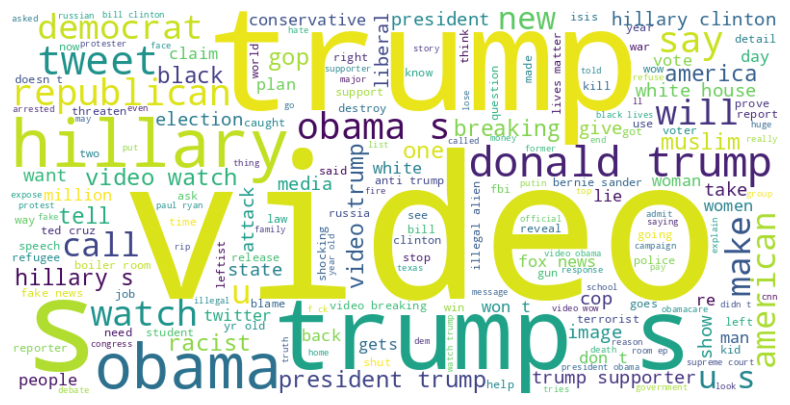

In [44]:
# Estrazione delle parole dai titoli delle fake news
words_fake = [word.lower() for title in fake_titles for word in word_tokenize(title)]

# Creazione della nuvola di parole
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words_fake))

# Visualizzazione della nuvola di parole
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Creazione modello per identificare fake news

In [87]:
df_full.sample(15)

,title,text,subject,date,label
11606,horrible maxine water call trump kremlin klan ...,notice left still push false narrative russian...,politics,"Feb 22, 2017",0
19882,uk threat level remain critical minister,london reuter threat level face britain remain...,worldnews,"September 16, 2017",1
6665,kremlin say washington must prove hack accusat...,tokyo reuter kremlin say friday united states ...,politicsNews,"December 16, 2016",1
10962,texas prosecutor offer probation antiabortion ...,houston reuter antiabortion activist indict us...,politicsNews,"February 4, 2016",1
145,two word gop congressman admit answer constituent,gop congress approval donald trump put forth y...,News,"November 3, 2017",0
4574,jan brewer birther democrats country video,donald trump supporter vigorously try blame an...,News,"September 18, 2016",0
23473,astroturfe journalist reveal brainwash tactic ...,vic bishop wake timesour reality carefully con...,Middle-east,"January 19, 2016",0
8154,democratic vp nominee kaine expect release med...,washington reuters democratic vice presidentia...,politicsNews,"September 14, 2016",1
16620,lords prayer ad bannedone month later muslim g...,america push back london red bus muslim sign s...,Government News,"May 9, 2016",0
18883,campus craziness student grade go use word man...,battle mankind take place inside northern ariz...,left-news,"Apr 1, 2017",0


In [104]:
# Preprocessing dei dati
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X = tfidf_vectorizer.fit_transform(df_full['text'])
y = df_full['label']

# Dividi i dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Addestramento del modello SVM
svm_model = SVC(kernel='linear', C=1.0)  # Utilizziamo un kernel lineare
svm_model.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4548
           1       0.99      1.00      0.99      4306

    accuracy                           0.99      8854
   macro avg       0.99      0.99      0.99      8854
weighted avg       0.99      0.99      0.99      8854



## VALUTAZIONE DEL MODELLO

In [105]:
# Valutazione del modello
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4548
           1       0.99      1.00      0.99      4306

    accuracy                           0.99      8854
   macro avg       0.99      0.99      0.99      8854
weighted avg       0.99      0.99      0.99      8854



## Esportazione del Modello

Una volta soddisfatto delle prestazioni del modello, esportalo utilizzando la libreria pickle in Python.
Assicurati di includere le istruzioni necessarie per caricare e utilizzare il modello.

In [106]:
import pickle
# Salva il modello utilizzando pickle
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

## ISTRUZIONI USO MODELLO SALVATO

Per caricare e utilizzare un modello SVM salvato con il formato pickle in Python, puoi seguire questi passaggi:

Importa le librerie necessarie:
python
Copia codice
import pickle
from sklearn import svm
Carica il modello SVM dal file pickle:
python
Copia codice
with open('nome_file_modello.pkl', 'rb') as f:
    modello_svm = pickle.load(f)
Assicurati di sostituire 'nome_file_modello.pkl' con il percorso e il nome del file in cui hai salvato il modello SVM.

Utilizza il modello per fare previsioni:
python
Copia codice
# Esempio di dati di input per la previsione
dato_di_input = [[valore_feature1, valore_feature2, ...]]

# Fai previsioni utilizzando il modello
previsione = modello_svm.predict(dato_di_input)
Con questi passaggi, hai caricato il modello SVM precedentemente salvato con pickle e hai fatto previsioni utilizzandolo con nuovi dati di input.

Ricorda di sostituire 'valore_feature1', 'valore_feature2', ... con i valori effettivi delle tue feature quando fai previsioni.